The content in this notebook was created using open source libraries as given below

MaskRCNN -> https://github.com/matterport/Mask_RCNN

https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

In [1]:
import os 
import sys 
from xml.etree import ElementTree
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from numpy import expand_dims
from numpy import mean
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
import numpy as np
import matplotlib.pyplot as plt

import cv2
from matplotlib.patches import Rectangle
from matplotlib import pyplot

Using TensorFlow backend.


# Data Prep for the model

In [2]:
class PartDataset(Dataset):
    # Extracting the boxes data from the images
    def extract_boxes(self, filename):

        # load and parse the repo
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)

        return boxes, width, height

    def load_dataset(self, dataset_dir, is_train=True):
        # Define just one class
        self.add_class("dataset", 1, "part")
        # define data locations
        images_dir = dataset_dir + "/images/"
        annotations_dir = dataset_dir + "/new_annot/"
        # find all images
        for filename in os.listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            
            if is_train and int(image_id) >= 25:
                continue
            if not is_train  and int(image_id) < 25:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id +".xml"
            # add to dataset
            self.add_image("dataset", image_id=image_id, path=img_path, annotation=ann_path)       

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        print(path)
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('part'))

        return masks, np.asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
# # train set
# train_set = PartDataset()
# data_dir = os.path.join(os.path.dirname(os.getcwd()), "part")
# train_set.load_dataset(data_dir, is_train=True)
# train_set.prepare()
# print('Train: %d' % len(train_set.image_ids))

In [ ]:
# # test/val set
# test_set = PartDataset()
# test_set.load_dataset(data_dir, is_train=False)
# test_set.prepare()
# print('Test: %d' % len(test_set.image_ids))

# Debugging

- Use code segment below to see if all the boxes are created in the right way

(402, 302, 3)
/home/vselvaraj/cs766/part/new_annot/00015.xml
(402, 302, 1)


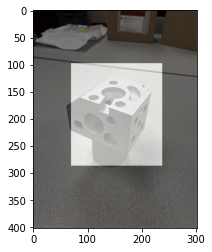

In [12]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "part")

# train set
train_set = PartDataset()
train_set.load_dataset(data_dir, is_train=True)
train_set.prepare()
# load an image
image_id = 4
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
plt.imshow(image)
# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

# Create Training and Test dataset

- Obtain the train and test data set and their corresponding xml files

In [13]:
# prepare test/val set
test_set = PartDataset()
test_set.load_dataset(data_dir, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 6


In [14]:
# Check to ensure if all the paths are loaded correctly
# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

{'id': '0004', 'source': 'dataset', 'path': '/home/vselvaraj/cs766/part/images/0004.jpg', 'annotation': '/home/vselvaraj/cs766/part/new_annot/0004.xml'}
{'id': '0003', 'source': 'dataset', 'path': '/home/vselvaraj/cs766/part/images/0003.jpg', 'annotation': '/home/vselvaraj/cs766/part/new_annot/0003.xml'}
{'id': '00010', 'source': 'dataset', 'path': '/home/vselvaraj/cs766/part/images/00010.jpg', 'annotation': '/home/vselvaraj/cs766/part/new_annot/00010.xml'}
{'id': '00019', 'source': 'dataset', 'path': '/home/vselvaraj/cs766/part/images/00019.jpg', 'annotation': '/home/vselvaraj/cs766/part/new_annot/00019.xml'}
{'id': '00015', 'source': 'dataset', 'path': '/home/vselvaraj/cs766/part/images/00015.jpg', 'annotation': '/home/vselvaraj/cs766/part/new_annot/00015.xml'}
{'id': '00011', 'source': 'dataset', 'path': '/home/vselvaraj/cs766/part/images/00011.jpg', 'annotation': '/home/vselvaraj/cs766/part/new_annot/00011.xml'}
{'id': '00012', 'source': 'dataset', 'path': '/home/vselvaraj/cs766/pa

# Training Config
- Use the code segment below if you plan to retrain the model with your own part

In [9]:
class PartConfig(Config):
    # A recognizable name for Config
    NAME = "part_cfg"
    # Classes
    NUM_CLASSES = 2
    # Training Epoch
    STEPS_PER_EPOCH = 24
    

In [10]:
# Prepare the Mask-RCNN model to be in the trainig configuration
config = PartConfig()

model_dir = os.path.join(os.path.dirname(os.getcwd()), "models")
model = MaskRCNN(mode="training", model_dir=model_dir, config=config)

In [ ]:
# load weights (mscoco) and exclude the output layers
weights_path = os.path.join(os.path.dirname(os.getcwd()), "models", 'mask_rcnn_coco.h5')
model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# Print the training output to console out rather than within the Jupyter Notebook
nb_stdout = sys.stdout
sys.stdout = open("/dev/stdout", "w")

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')

sys.stdout = nb_stdout

# Predicting Config
- Use the code segment below if you plan to predict using the model

In [16]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "part_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [17]:
# create config
cfg = PredictionConfig()
# define the model
model_dir = os.path.join(os.path.dirname(os.getcwd()), "models", "part_cfg20210504T1653") 
model = MaskRCNN(mode='inference', model_dir=model_dir, config=cfg)

In [18]:
# load model weights
weights_dir = os.path.join(os.path.dirname(os.getcwd()), "models", "part_cfg20210504T1653", 'mask_rcnn_part_cfg_0010.h5')
model.load_weights(weights_dir, by_name=True)

Re-starting from epoch 10


In [21]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [22]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

/home/vselvaraj/cs766/part/new_annot/0004.xml
/home/vselvaraj/cs766/part/new_annot/0003.xml
/home/vselvaraj/cs766/part/new_annot/00010.xml
/home/vselvaraj/cs766/part/new_annot/00019.xml
/home/vselvaraj/cs766/part/new_annot/00015.xml
/home/vselvaraj/cs766/part/new_annot/00011.xml
/home/vselvaraj/cs766/part/new_annot/00012.xml
/home/vselvaraj/cs766/part/new_annot/00018.xml
/home/vselvaraj/cs766/part/new_annot/00022.xml
/home/vselvaraj/cs766/part/new_annot/00020.xml
/home/vselvaraj/cs766/part/new_annot/0009.xml
/home/vselvaraj/cs766/part/new_annot/00017.xml
/home/vselvaraj/cs766/part/new_annot/0001.xml
/home/vselvaraj/cs766/part/new_annot/00023.xml
/home/vselvaraj/cs766/part/new_annot/00014.xml
/home/vselvaraj/cs766/part/new_annot/00013.xml
/home/vselvaraj/cs766/part/new_annot/0005.xml
/home/vselvaraj/cs766/part/new_annot/0008.xml
/home/vselvaraj/cs766/part/new_annot/00024.xml
/home/vselvaraj/cs766/part/new_annot/0007.xml
/home/vselvaraj/cs766/part/new_annot/0006.xml
/home/vselvaraj/cs766

In [35]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

/home/vselvaraj/cs766/part/new_annot/00028.xml
/home/vselvaraj/cs766/part/new_annot/00029.xml
/home/vselvaraj/cs766/part/new_annot/00030.xml
/home/vselvaraj/cs766/part/new_annot/00025.xml
/home/vselvaraj/cs766/part/new_annot/00026.xml


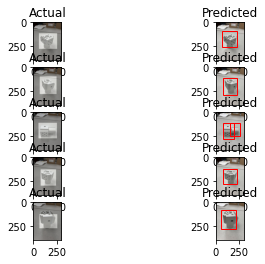

In [36]:
plot_actual_vs_predicted(test_set, model, cfg)

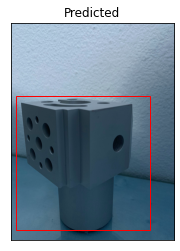

In [77]:
# Predict your custom file

file_name = "10.png"
new_image = cv2.imread("./new_images/" + file_name)
# convert pixel values (e.g. center)
scaled_image = mold_image(new_image, cfg)
# convert image into one sample
sample = expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)

pyplot.imshow(new_image)
pyplot.title('Predicted')
ax = pyplot.gca()
y1, x1, y2, x2 = yhat[0]["rois"][0]
width, height = x2 - x1, y2 - y1
rect = Rectangle((x1, y1), width, height, fill=False, color='red')
ax.add_patch(rect)
ax.set_xticks([])
ax.set_yticks([])

pred_save_path = os.path.join("new_images", "predicted", file_name)
plt.savefig(pred_save_path)